In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 6 2024

@author: Yaning
Suggested by Sascha
"""

import torch
import pyro
import math
import pandas as pd
from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform
from pyro.distributions.util import scalar_like
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.mcmc.util import initialize_model, summary
from pyro.util import ignore_experimental_warning
from pyro import poutine
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_960898/1020090210.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
class Agent:
    def __init__(self, ds_rate, variance):
        # free parameters (the mean and variant of the estimate value)
        self.ds_rate = ds_rate
        self.variance = variance


    def estimation(self, curr_LL, curr_delay, curr_SS):
        # the estimate value is assumed to be a normal distribution
        # the estimate value mean is assumed to LL/1+kt
        # the estimate value variant is set to be 4
        self.LL_es_mu = curr_LL/(1+self.ds_rate*curr_delay)
        self.LL_es_sigma = self.variance
        # the fixed early and small value
        self.curr_SS = curr_SS


    def generate_action(self):
        # 1 means choosing large later
        # pyro distribution is used (i guess it is the same as torch's distribution)
        # somehow using binomial or bernoulli is a bit slower to generate the data
        # maybe because there are two distributions? 
        LL_distri = Normal(loc = torch.tensor(self.LL_es_mu), scale =torch.tensor(self.LL_es_sigma))
        chose_LL_pobs = 1 - LL_distri.cdf(torch.tensor(self.curr_SS))
        LL_bino = Binomial(probs = chose_LL_pobs)
        return LL_bino.sample().item()

In [3]:
# discounting rate is 1/16, the uncertainty which is the variance is 4 for now
agent = Agent(1/16, 4)

LL_values = []
combinations = []
# future tensor for inference specifically
inference_actions = []
inference_ss_values = []
inference_ll_values = []
inference_delays = []

actions = []
choose_percentage = []

# initialise trial combinations
repetition = 10
delays = [1, 3, 7, 13, 24, 32, 45, 58, 75, 122]
SS_values = [5]
# values by percentage
LL_values_p = [1.05, 1.055, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.85, 1.9, 2.05, 2.25, 2.55, 2.85, 3.05, 3.45, 3.85]


# get the LL_values
for S in SS_values:
    for L in LL_values_p:
        LL_values.append(S*L)

# combinations has three parameters: SS_value, LL_value, delay
for S in SS_values:
    for delay in delays:
        for L in LL_values:
            combinations.append([L, delay, S])

for trial in combinations:
    one_combination_action = []
    for repeat in range(repetition):
        # parameters estimation needs: curr_LL, curr_delay, curr_SS
        agent.estimation(trial[0], trial[1], trial[2])
        generated_action = agent.generate_action()

        # arrays that are used for inference
        inference_ll_values.append(trial[0])
        inference_delays.append(trial[1])
        inference_ss_values.append(trial[2])
        inference_actions.append(generated_action)

        one_combination_action.append(generated_action)

    # 1 means choose large later
    choose_percentage.append((len(list(filter(lambda x: (x == 1), one_combination_action))) / len(one_combination_action)) * 100)
    actions.append(one_combination_action)


 
d = {'combinations':combinations, 'actions': actions, 'choose_percentage': choose_percentage}
df = pd.DataFrame(data=d)
print(df)
print(inference_actions)

                   combinations  \
0                  [5.25, 1, 5]   
1    [5.2749999999999995, 1, 5]   
2                  [5.75, 1, 5]   
3                  [6.25, 1, 5]   
4                  [6.75, 1, 5]   
..                          ...   
165             [12.75, 122, 5]   
166             [14.25, 122, 5]   
167             [15.25, 122, 5]   
168             [17.25, 122, 5]   
169             [19.25, 122, 5]   

                                               actions  choose_percentage  
0    [1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...               60.0  
1    [0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...               70.0  
2    [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...               50.0  
3    [1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...               60.0  
4    [0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...               60.0  
..                                                 ...                ...  
165  [1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0

In [4]:
delays

[1, 3, 7, 13, 24, 32, 45, 58, 75, 122]

In [5]:

actions = torch.tensor(inference_actions)
delays = torch.tensor(inference_delays)
ss_values = torch.tensor(inference_ss_values)
ll_values = torch.tensor(inference_ll_values)
# print(actions)
# print(delays)
# print(ss_values)
# print(ll_values)

def model(actions, delays, ss_values, ll_values):
    dev = pyro.sample("dev", HalfCauchy(scale=torch.tensor([4.])))
    rate = pyro.sample("rate", HalfCauchy(scale= torch.tensor([1.])))
    num = actions.shape[0]
    with pyro.plate("num", num):
        mean = ll_values/(1+rate*delays)
        print(len(mean))
        distri = Normal(loc = mean, scale = dev)
        pos = 1 - distri.cdf(ss_values)
        return pyro.sample("obs", Binomial(probs = pos), obs=actions)

# pyro.render_model(model, model_args=(actions, delays, ss_values, ll_values), render_params=True, render_distributions=True)



mcmc_kernel = NUTS(model)                                               # initialize proposal distribution kernel
mcmc = MCMC(mcmc_kernel, num_samples=300, num_chains = 3, warmup_steps=50)  # initialize MCMC class
mcmc.run(actions, delays, ss_values, ll_values)

Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/350 [00:00, ?it/s]

/home/yaning/Documents/python_env/pyro/lib/python3.11/site-packages/torch/__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


1700

/home/yaning/Documents/python_env/pyro/lib/python3.11/site-packages/torch/__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)



1700
1700


/home/yaning/Documents/python_env/pyro/lib/python3.11/site-packages/torch/__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


1700
17001700

1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
17001700

1700
17001700

1700
17001700

1700
17001700

1700
17001700

1700
17001700

1700
17001700

1700
1700
17001700

1700
17001700

1700
17001700

1700
17001700

1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
17001700

1700
17001700

1700
17001700

1700
17001700

1700
17001700

1700
17001700

1700
17001700

1700
17001700

1700
17001700

1700
17001700

1700
1700
1700
1700
17001700

1700
17001700

1700
17001700

1700
17001700

1700
17001700

170017001700


170017001700


17001700

1700
17001700
1700

1700
17001700

1700
17001700

1700
1700
1700
1700
1700
17001700

1700
17001700

1700
17001700

1700
17001700
1700

17001700
1700

17001700
1700

170017001700


170017001700


170017001700


1700
17001700

1700
1700
1700
17001700

1700
17001700
1700

17001700

1700
17001700

1700
1700
1700
1700
1700
17001700

1700
1700
1700
1700
17001700

1700
17001700

1700
17001700

1700
17001700
1

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700
1700

In [6]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    dev[0]      4.03      0.42      3.98      3.66      4.30     81.58      1.03
   rate[0]      0.05      0.00      0.05      0.05      0.06    577.76      1.01

Number of divergences: 2


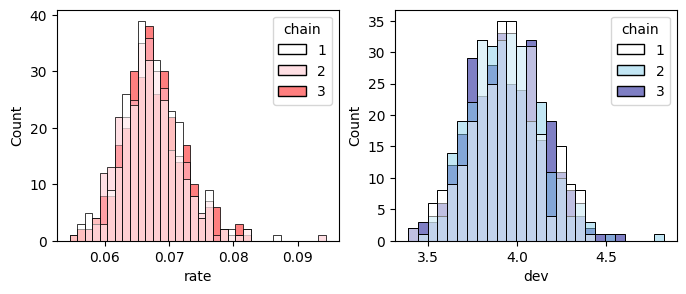

In [5]:
# mcmc.summary()
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

rate = pd.DataFrame(mcmc.get_samples()['rate'],columns=['rate'])
rate['chain'] = torch.tensor([1,2,3]).repeat(300)
sns.histplot(data=rate, x='rate',hue='chain', palette=['white', 'pink', 'red'], ax=axs[0])

dev = pd.DataFrame(mcmc.get_samples()['dev'],columns=['dev'])
dev['chain'] = torch.tensor([1,2,3]).repeat(300)
sns.histplot(data=dev, x='dev',hue='chain', palette=['white', 'skyblue', 'darkblue'], ax=axs[1])

plt.show()